## Import Library

In [1]:
import numpy as np
import pandas as pd 
import re
import os
import string
from string import digits
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

2023-05-21 14:09:55.749527: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-21 14:09:55.916084: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-21 14:09:55.916118: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-21 14:09:56.674957: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

## Load the Data Sets

In [2]:
lines=pd.read_csv("Hindi_English_Truncated_Corpus_H2E.csv",encoding='utf-8')

In [3]:
len(lines)

127607

In [4]:
lines['source'].value_counts()

tides        50000
ted          39881
indic2012    37726
Name: source, dtype: int64

In [5]:
lines = lines[lines['source'].isin(['ted', 'tides'])]

In [6]:
lines.head(20)

,source,hindi_sentence,english_sentence
0,ted,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर...",politicians do not have permission to do what ...
1,ted,मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...,"I'd like to tell you about one such child,"
3,ted,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते,what we really mean is that they're bad at not...
5,tides,कश्मीर के तत्कालीन गवर्नर ने इस हस्तांतरण का व...,The then Governor of Kashmir resisted transfer...
7,ted,और हम होते कौन हैं यह कहने भी वाले कि वे गलत हैं,"And who are we to say, even, that they are wrong"
9,tides,हो सकता है कि आप चाहते हों कि आप का नऋर्नमेनटे...,You may want your child to go to a school that...
10,tides,कृपया यह सुनिश्चित कर लें कि आप सही फॉर्म का प...,Please ensure that you use the appropriate form .
13,ted,तो वहाँ न्याय है,So there is some sort of justice
14,tides,पहले दो को अविश्वसनीय मानकर बाकी पांच मुखबिरों...,The first two were found unreliable and the pr...
15,tides,कम संख़्या वाले उच्च एवं मध्यम श्रेणी के लोगों...,They had justified their educational policy of...


In [7]:
len(lines)

89881

In [8]:
# Count the null values in each column
pd.isnull(lines).sum()

source              0
hindi_sentence      0
english_sentence    0
dtype: int64

In [9]:
# Select record with Not Null values
lines=lines[~pd.isnull(lines['hindi_sentence'])]

In [10]:
# Drop the duplicates record
lines.drop_duplicates(inplace=True)

In [11]:
# Filter 75K Records
lines=lines.sample(n=75000,random_state=42)
lines.shape

(75000, 3)

## Preprocess the Datasets

In [12]:
# Lowercase all characters
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: x.lower())
lines['english_sentence']=lines['english_sentence'].apply(lambda x: x.lower())

In [13]:
# Remove quotes
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: re.sub("'", '', x))
lines['english_sentence']=lines['english_sentence'].apply(lambda x: re.sub("'", '', x))

In [14]:
exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines['english_sentence']=lines['english_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [15]:
# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
lines['english_sentence']=lines['english_sentence'].apply(lambda x: x.translate(remove_digits))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: x.translate(remove_digits))
lines['hindi_sentence'] = lines['hindi_sentence'].apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))

# Remove extra spaces
lines['english_sentence']=lines['english_sentence'].apply(lambda x: x.strip())
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: x.strip())
lines['english_sentence']=lines['english_sentence'].apply(lambda x: re.sub(" +", " ", x))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: re.sub(" +", " ", x))

In [16]:
# Add start and end tokens to target sequences
lines['english_sentence'] = lines['english_sentence'].apply(lambda x : 'START_ '+ x + ' _END')

In [17]:
lines.head()

,source,hindi_sentence,english_sentence
8527,tides,सभी प्रकार का कमर दर्द इस रोग का प्रमुख लक्षण ...,START_ all kinds of back pain are a primary sy...
52948,tides,मार्च के प्रारंभ में महात्मा गांधी ने ब्रिटिश ...,START_ early in march the mahatma served his h...
11574,ted,अपने शहरों और अपने ही देशों मे।,START_ in cities in their own communities _END
32922,ted,अपने स्टूडियो में हिप हॉप कलाकार विलइऍम का,START_ of hip hop artist william into their st...
92845,tides,यह जुलूस दोनों धर्मों के कट्टरपंथियों का जुलूस...,START_ this was a joint protest by the orthodo...


In [18]:
### Get English and Hindi Vocabulary
all_hindi_words=set()
for hin in lines['hindi_sentence']:
    for word in hin.split():
        if word not in all_hindi_words:
            all_hindi_words.add(word)

all_eng_words=set()
for eng in lines['english_sentence']:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)

In [19]:
print("Count of Hindi Word : ",len(all_hindi_words))
print("Count of English Word : ",len(all_eng_words))

Count of Hindi Word :  66418
Count of English Word :  46377


In [20]:
lines['length_hin_sentence']=lines['hindi_sentence'].apply(lambda x:len(x.split(" ")))
lines['length_eng_sentence']=lines['english_sentence'].apply(lambda x:len(x.split(" ")))

In [21]:
lines.head()

,source,hindi_sentence,english_sentence,length_hin_sentence,length_eng_sentence
8527,tides,सभी प्रकार का कमर दर्द इस रोग का प्रमुख लक्षण ...,START_ all kinds of back pain are a primary sy...,25,26
52948,tides,मार्च के प्रारंभ में महात्मा गांधी ने ब्रिटिश ...,START_ early in march the mahatma served his h...,31,33
11574,ted,अपने शहरों और अपने ही देशों मे।,START_ in cities in their own communities _END,7,8
32922,ted,अपने स्टूडियो में हिप हॉप कलाकार विलइऍम का,START_ of hip hop artist william into their st...,8,10
92845,tides,यह जुलूस दोनों धर्मों के कट्टरपंथियों का जुलूस...,START_ this was a joint protest by the orthodo...,40,35


In [22]:
lines[lines['length_eng_sentence']>30].shape

(9338, 5)

In [23]:
lines=lines[lines['length_eng_sentence']<=20]
lines=lines[lines['length_hin_sentence']<=20]

In [24]:
lines.shape

(50205, 5)

In [25]:
print("maximum length of Hindi Sentence ",max(lines['length_hin_sentence']))
print("maximum length of English Sentence ",max(lines['length_eng_sentence']))

maximum length of Hindi Sentence  20
maximum length of English Sentence  20


In [26]:
max_length_src=max(lines['length_hin_sentence'])
max_length_tar=max(lines['length_eng_sentence'])

In [27]:
input_words = sorted(list(all_hindi_words))
target_words = sorted(list(all_eng_words))
num_encoder_tokens = len(all_hindi_words)
num_decoder_tokens = len(all_eng_words)
num_encoder_tokens, num_decoder_tokens

(66418, 46377)

In [28]:
num_decoder_tokens += 1 #for zero padding
num_encoder_tokens = num_encoder_tokens + 1

In [29]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [30]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [31]:
lines = shuffle(lines)
lines.head(10)

,source,hindi_sentence,english_sentence,length_hin_sentence,length_eng_sentence
86656,ted,और दुनिया को बेहतर बना रहे है ।,START_ and making a better world _END,8,7
10211,tides,इतनी जटिलताओं से बचने को अर्ग्नि का जन्म हुआ,START_ to avoid such a complex trajectory the ...,9,13
20022,tides,चरवाहे ने आकर उससे प्रार्थना की कि आदमी भेजकर ...,START_ the cowherd came to basava and begged h...,12,18
92670,ted,इस बात की कि अनुदान आखिर क्या है और क्या हो सक...,START_ of what aid is and can be _END,13,9
38767,ted,फिर में मैप map उपग्रह फिर wmap,START_ and then in the map satellite was launc...,7,12
17348,tides,इस दिशा में बहुत तेजी से अनुसंधान किए जा रहे हैं,START_ research is progressing very rapidly in...,11,10
100771,ted,हमारी फ़ाउण्डेशन ने एक वैक्सीन पर काम किया है ...,START_ our foundation has backed a vaccine tha...,16,14
9471,tides,संग न ने गृह मंत्रालय के किसी भी बयान या घोषणा...,START_ it dubbed any statement or declaration ...,19,20
96378,ted,मैं उन्हें पारित कैसे करता मुझे उन्हें और अधिक...,START_ how do i get them to pass i have to get...,13,16
39371,ted,ये और भी बेहतर हो जाता है,START_ it gets way better _END,7,6


## Split the data into train and test

In [32]:
X, y = lines['hindi_sentence'], lines['english_sentence']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=42)
X_train.shape, X_test.shape

((40164,), (10041,))

In [33]:
## Let us save this data
X_train.to_pickle('X_train.pkl')
X_test.to_pickle('X_test.pkl')

In [34]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

## Encoder-Decoder Architecture

In [35]:
latent_dim = 300

In [36]:
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

2023-05-21 14:11:37.892832: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-21 14:11:37.892869: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-21 14:11:37.892897: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (csis-ProLiant-DL380-Gen10): /proc/driver/nvidia/version does not exist
2023-05-21 14:11:37.893336: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [37]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [38]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [39]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 300)    19925700    ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 300)    13913400    ['input_2[0][0]']                
                                                                                              

## Model Training

In [40]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 54

In [41]:
%%time
history = model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

/home/sunil/sunil2_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/54
313/313 [==============================] - 636s 2s/step - loss: 6.9971 - val_loss: 6.6033
Epoch 2/54
313/313 [==============================] - 887s 3s/step - loss: 6.5601 - val_loss: 6.5729
Epoch 3/54
313/313 [==============================] - 1001s 3s/step - loss: 6.5303 - val_loss: 6.5610
Epoch 4/54
313/313 [==============================] - 1014s 3s/step - loss: 6.5014 - val_loss: 6.5137
Epoch 5/54
313/313 [==============================] - 1239s 4s/step - loss: 6.4255 - val_loss: 6.4243
Epoch 6/54
313/313 [==============================] - 1273s 4s/step - loss: 6.3192 - val_loss: 6.3064
Epoch 7/54
313/313 [==============================] - 1293s 4s/step - loss: 6.1918 - val_loss: 6.1998
Epoch 8/54
313/313 [==============================] - 1260s 4s/step - loss: 6.0858 - val_loss: 6.1036
Epoch 9/54
313/313 [==============================] - 1292s 4s/step - loss: 6.0013 - val_loss: 6.0376
Epoch 10/54
313/313 [==============================] - 1291s 4s/step - loss: 5.9281 

In [79]:
model.save('MT_Hindi_Eng_50_H2E.h5')

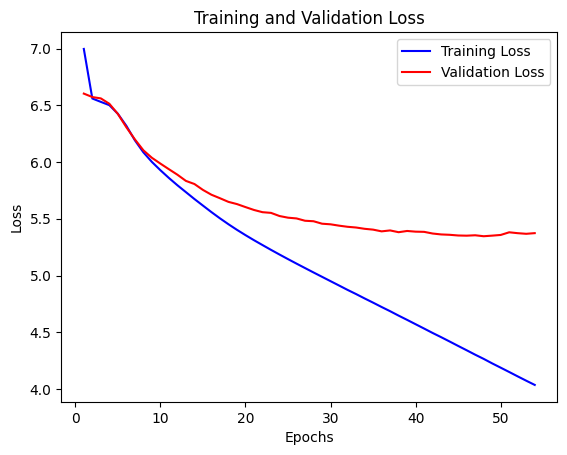

In [45]:
# Get the training and validation loss values
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot the loss curve
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [46]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [47]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [64]:
import sacrebleu
def calculate_bleu(reference, hypothesis):
    bleu = sacrebleu.corpus_bleu(hypothesis, [reference])
     # Print the BLEU score
    x = bleu.score/100
    print("BLEU Score:",x) 

In [65]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [73]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input Hindi sentence:', X_train[k:k+1].values[0])
reference = y_train[k:k+1].values[0][6:-4]
reference = [reference]
print('Actual English Translation:', reference)
predicted = decoded_sentence[:-4]
predicted = [predicted]
print('Predicted English Translation:', predicted)
calculate_bleu(reference, predicted)

1/1 [==============================] - 0s 33ms/step
Input Hindi sentence: तो वो तेज़ी से आगे निकल गये।
Actual English Translation: [' they just race ahead ']
Predicted English Translation: [' they were able to take a little bit of them ']
BLEU Score: 0.04196114906296548


In [74]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input Hindi sentence:', X_train[k:k+1].values[0])
reference = y_train[k:k+1].values[0][6:-4]
reference = [reference]
print('Actual English Translation:', reference)
predicted = decoded_sentence[:-4]
predicted = [predicted]
print('Predicted English Translation:', predicted)
calculate_bleu(reference, predicted)

1/1 [==============================] - 0s 33ms/step
Input Hindi sentence: और उन सबको एक प्रमाणपत्र चाहिये होता है।
Actual English Translation: [' and they all want a certificate ']
Predicted English Translation: [' and they have to be a very good ']
BLEU Score: 0.12223075560872519


In [75]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input Hindi sentence:', X_train[k:k+1].values[0])
reference = y_train[k:k+1].values[0][6:-4]
reference = [reference]
print('Actual English Translation:', reference)
predicted = decoded_sentence[:-4]
predicted = [predicted]
print('Predicted English Translation:', predicted)
calculate_bleu(reference, predicted)

1/1 [==============================] - 0s 32ms/step
Input Hindi sentence: एक सुपरकंप्यूटर सघन बनाने के लिये
Actual English Translation: [' into supercomputing collectives ']
Predicted English Translation: [' in a way of a brain ']
BLEU Score: 0.0


In [77]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input Hindi sentence:', X_train[k:k+1].values[0])
reference = y_train[k:k+1].values[0][6:-4]
reference = [reference]
print('Actual English Translation:', reference)
predicted = decoded_sentence[:-4]
predicted = [predicted]
print('Predicted English Translation:', predicted)
calculate_bleu(reference, predicted)

1/1 [==============================] - 0s 34ms/step
Input Hindi sentence: हम और साल के खिलड़ियों की ओर देख रहे हैं ताकि उनका बेहतर उपयोग किया जा सके
Actual English Translation: [' we are looking at and yearolds to make use of them ” ']
Predicted English Translation: [' we have to go back to the time they are and in']
BLEU Score: 0.04789232204309912
